# Import libraries

In [1]:
# Basic data manipulation libraries
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.tools.plotting import scatter_matrix

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Common model algorithms
from sklearn import linear_model, svm, tree, naive_bayes, ensemble
from xgboost import XGBRegressor

# Common model helpers
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

# Import Data

In [4]:
# my_data = pd.read_csv('data/train.csv')
my_data = pd.read_csv('data/train.csv')
my_data.head()

x0        x1        x2        x3        x4        x5        x6  \
0  0.001567 -0.002716 -0.002616  0.001542  0.000444  0.001355  0.002986   
1 -0.003053  0.002341  0.000214 -0.003934  0.000273 -0.003462 -0.001406   
2  0.001435  0.001712 -0.000067 -0.002087  0.001251 -0.000157 -0.001618   
3  0.001913  0.000249 -0.000782  0.000161  0.000719  0.000928 -0.000651   
4 -0.003259  0.005571 -0.000398 -0.003332 -0.000677  0.000233  0.000105   

             x7        x8        x9    ...     x91       x92       x93  \
0 -5.021082e-07 -0.003574  0.002277    ...       T -0.001178  0.001122   
1 -2.909420e-03  0.003511  0.002110    ...       W  0.003067 -0.000560   
2  1.684093e-03 -0.004051  0.000440    ...       W -0.000250  0.001027   
3  2.501691e-03 -0.002954 -0.001270    ...       W -0.000643  0.000905   
4 -1.540297e-04  0.000742  0.000997    ...       W  0.002608  0.000794   

        x94       x95       x96       x97       x98       x99         y  
0 -0.002745  0.000074 -0.002104 -0.002863 -0.002665  0.000395  0.309301  
1 -0.002201  0.000443  0.002012  0.000383  0.001683  0.002143  0.423396  
2  0.003646  0.001145 -0.001239  0.003026  0.002528  0.001107  0.132837  
3 -0.000038 -0.000178  0.000489  0.000936  0.000920 -0.000790  0.340411  
4  0.002171 -0.000566  0.000077  0.000907  0.000204  0.000824  0.719293  

[5 rows x 101 columns]

In [5]:
print('Data dimension: {}'.format(my_data.shape))

Data dimension: (8000, 101)


# Data Cleaning

## Data Completeness

The goal of this step is to check if there are any missing values and to determine how to process missing values.

In [6]:
missing_rate = {}
for feature in my_data.columns:
    missing_rate[feature] = 100 * my_data[feature].isna().sum()/len(my_data[feature])
missing_rate_df = pd.DataFrame(list(missing_rate.values()), index=missing_rate.keys(), columns=['missing_rate'])
missing_rate_df['data_type'] = my_data.dtypes
missing_rate_df.head()

missing_rate data_type
x0        0.0000   float64
x1        0.0125   float64
x2        0.0000   float64
x3        0.0000   float64
x4        0.0000   float64

In [7]:
print('The maximum missing rate is {}%'.format(np.max(missing_rate_df['missing_rate'])))

The maximum missing rate is 0.05%


The **train.csv** has very low missing value rate. The maximum missing rate is 0.05%.

In [8]:
categorical_variables = list(missing_rate_df.loc[missing_rate_df.data_type == 'object',].index)
categorical_variables

quantitative_variables = list(set(my_data.columns) - set(categorical_variables) - set('y'))
quantitative_variables

print('Number of categorical variables: {}'.format(len(categorical_variables)))
print('Number of quantitative variables: {}'.format(len(quantitative_variables)))

Number of categorical variables: 3
Number of quantitative variables: 97


### Impute missing values

* For categorical variables, we fill the missing values with mode.
* For quantitative variables, we visualize the distribution with boxplots and see if the variable has too many outliers. If yes, we fill missing values with **median**. Otherwise, we use the **mean**.

**Barplots on categorical variables**

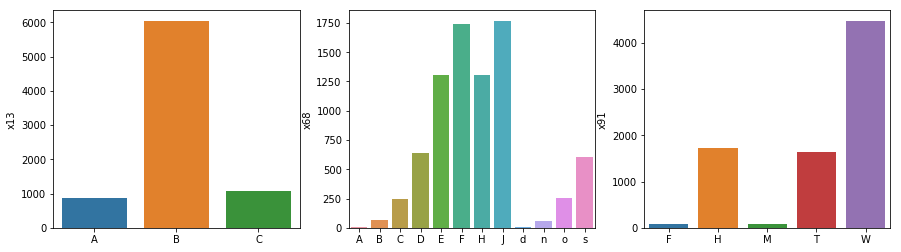

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
for i in range(len(categorical_variables)):
    f = categorical_variables[i]
    df = my_data[f].value_counts()
    df = df.sort_index()
    sns.barplot(df.index, df, ax=axs[i])

**Violinplots on quantitative variables**

In [10]:
my_data[sorted(my_data.columns)].head()

x0        x1       x10       x11       x12 x13       x14       x15  \
0  0.001567 -0.002716  0.001166 -0.004272  0.001357   B  0.006459  0.001298   
1 -0.003053  0.002341  0.000130  0.001720 -0.001639   B  0.001058  0.002080   
2  0.001435  0.001712 -0.000184 -0.001161 -0.002717   B -0.001738  0.000559   
3  0.001913  0.000249 -0.001493  0.001849 -0.001108   B  0.001223  0.000116   
4 -0.003259  0.005571  0.000829  0.001113 -0.003479   B -0.001870 -0.001670   

        x16       x17    ...     x91       x92       x93       x94       x95  \
0 -0.001858 -0.003086    ...       T -0.001178  0.001122 -0.002745  0.000074   
1 -0.000407  0.003868    ...       W  0.003067 -0.000560 -0.002201  0.000443   
2  0.001972 -0.002340    ...       W -0.000250  0.001027  0.003646  0.001145   
3 -0.001404 -0.000106    ...       W -0.000643  0.000905 -0.000038 -0.000178   
4  0.000835 -0.000406    ...       W  0.002608  0.000794  0.002171 -0.000566   

        x96       x97       x98       x99         y  
0 -0.002104 -0.002863 -0.002665  0.000395  0.309301  
1  0.002012  0.000383  0.001683  0.002143  0.423396  
2 -0.001239  0.003026  0.002528  0.001107  0.132837  
3  0.000489  0.000936  0.000920 -0.000790  0.340411  
4  0.000077  0.000907  0.000204  0.000824  0.719293  

[5 rows x 101 columns]

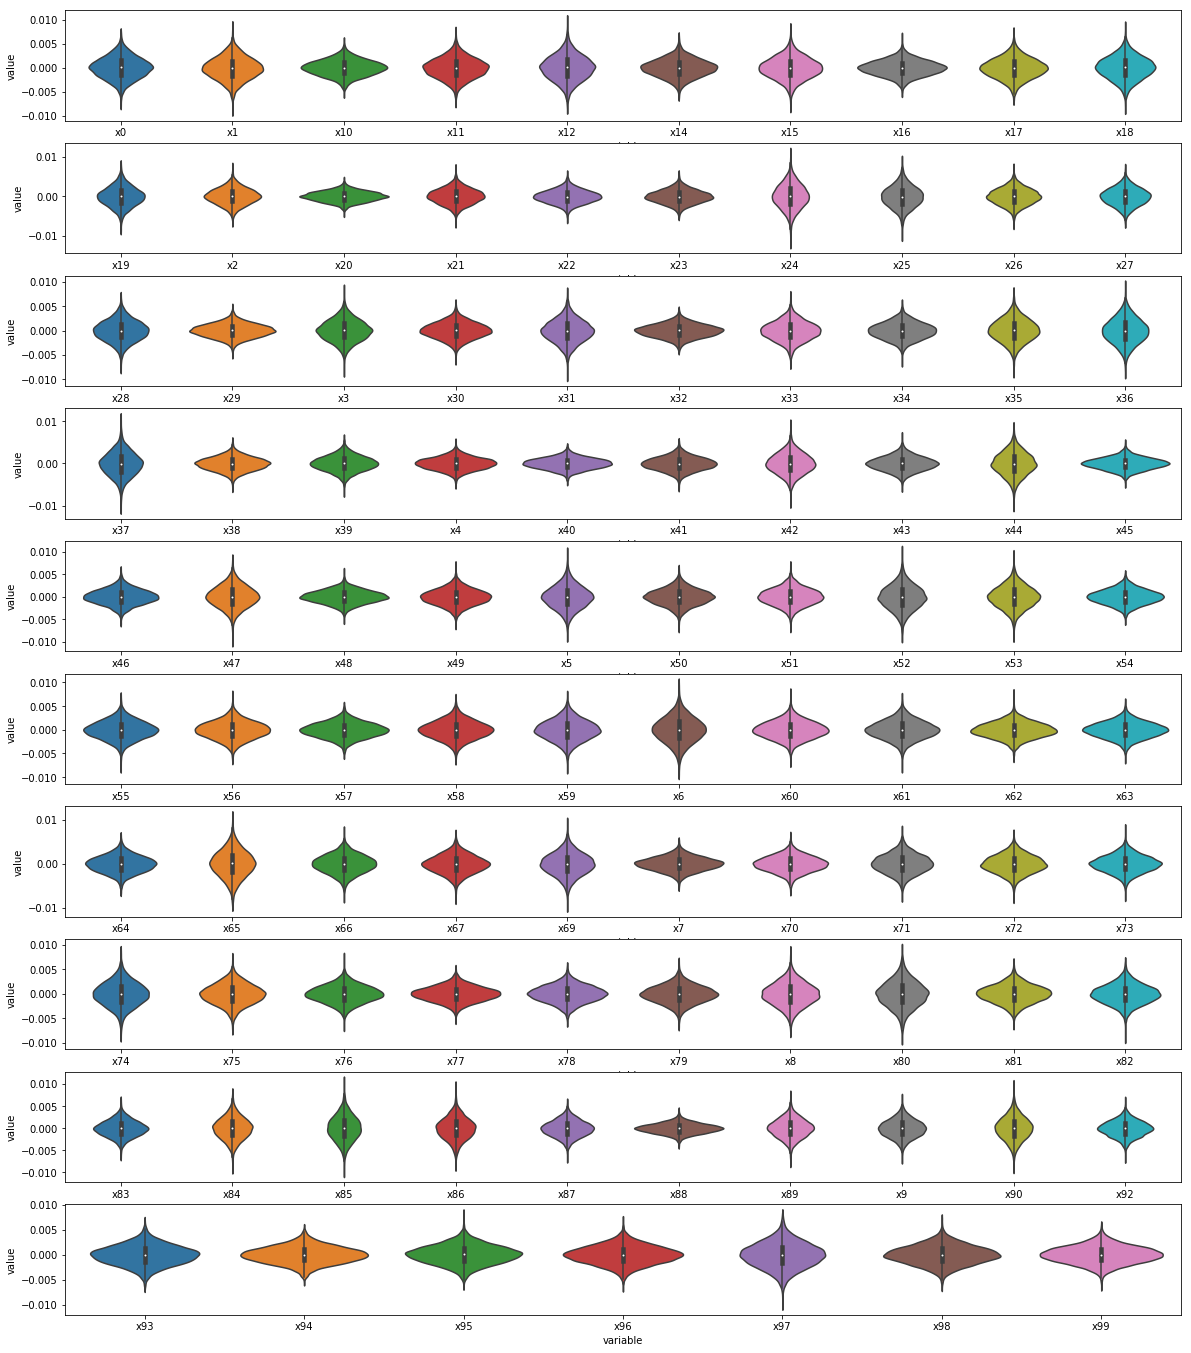

In [11]:
quantitative_variables = sorted(quantitative_variables)
fig, axs = plt.subplots(10, 1, figsize=(20,24)) 
for i in range(10):
    cols = quantitative_variables[i*10:(i+1)*10]
    if i == 9:
        cols = quantitative_variables[i*10:]
    df = my_data[cols]
    sns.violinplot(x="variable", y="value", data=df.melt(), ax=axs[i])

<span style="color:red">**Useful information from this step**</span>

+ The violinplots show that almost all quantitative variables have pretty much symmetric distribution with some extreme values. Both median and mean would be a good value for filling missing values.

In [12]:
# fill missing values in quantitative variables with median
for x in quantitative_variables:
    my_data[x].fillna(my_data[x].median(), inplace=True)
    
# fill missing values in categorical variables with mode
for x in categorical_variables:
    my_data[x].fillna(my_data[x].mode()[0], inplace=True)

Recheck the completeness of the data.

In [13]:
for x in my_data.columns:
    off = True
    missing_rate = my_data[x].isnull().sum()/my_data.shape[0]
    if  missing_rate != 0:
        print('{:<10} {}%'.format(x, missing_rate))
if off:
    print('Good. No variable has missing value!')

Good. No variable has missing value!


# Exploratory Data Analysis

Let's check the correlation among explanatory variables.

In [14]:
quant_corr_matrix = my_data[quantitative_variables].corr()

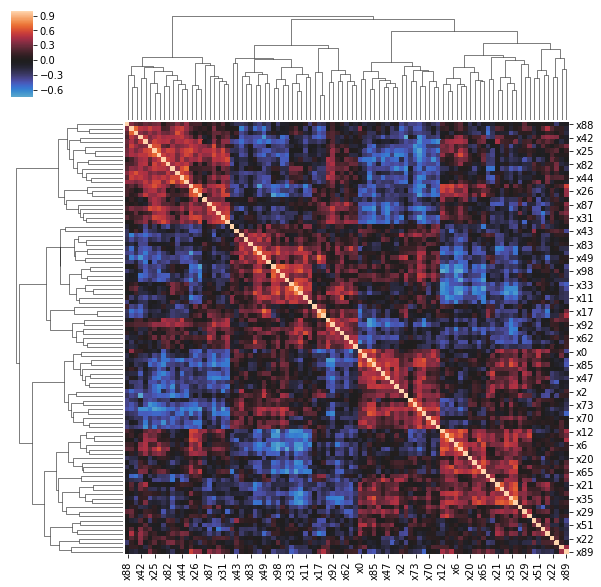

In [15]:
sns.clustermap(quant_corr_matrix, center=0)
plt.show()

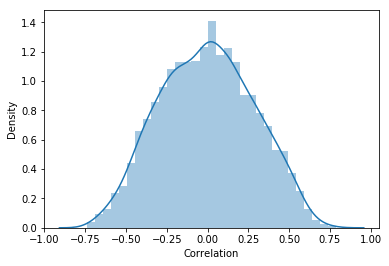

In [16]:
# Plot the density of correlation coefficients
corrs = np.array(quant_corr_matrix)[np.triu_indices(97, 1)]
sns.distplot(corrs)
ax = plt.gca()
ax.set_xlabel('Correlation')
ax.set_ylabel('Density')
plt.show()

<span style="color:red">**Useful information from this step**</span>

+ The cluster heatmap shows which explanatory variables are correlated and to what extend they are correlated. 
+ The density plot shows the distribution of correlation coefficients.
+ These two plots indicate that the majority of coefficient values are between (-0.5, 0.5), which means the correlation among explanatory variables are not very strong. This is good for modeling the data. 

## Check relationship between explanatory variables and the target variable


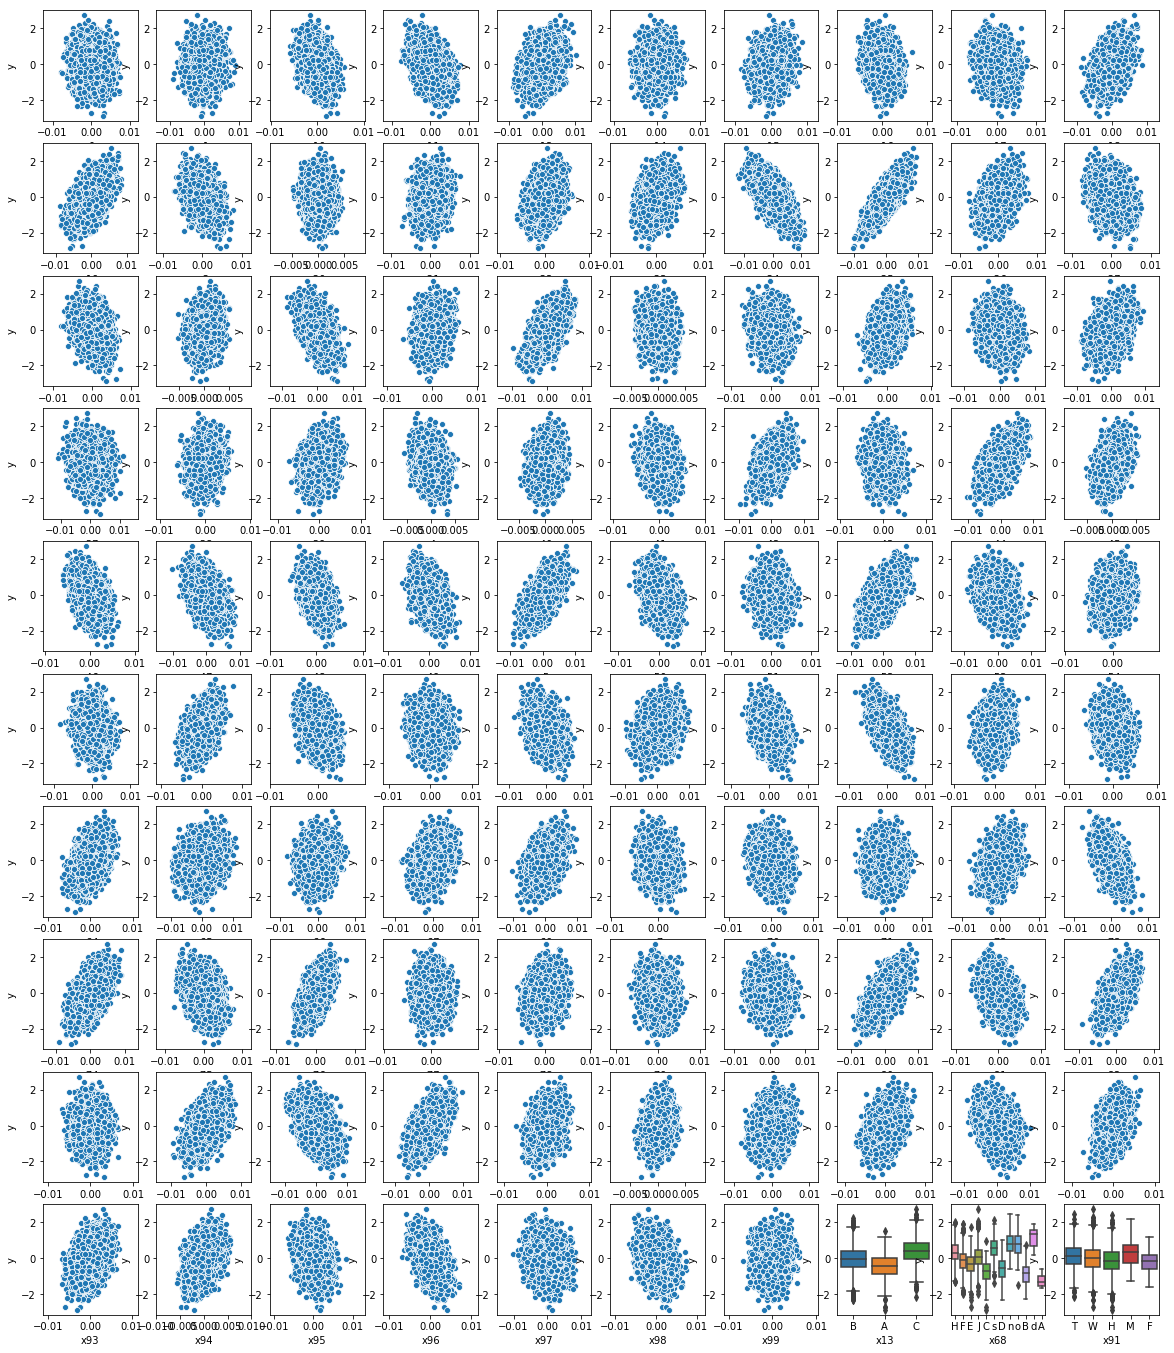

In [17]:
quantitative_variables = sorted(quantitative_variables)
fig, axs = plt.subplots(10, 10, figsize=(20, 24)) 
for i in range(len(quantitative_variables)):
    row_index = i // 10
    col_index = i % 10
    f = quantitative_variables[i]
    df = my_data[[f, 'y']]
    sns.scatterplot(x=f, y="y", data=df, ax=axs[row_index][col_index])
sns.boxplot(x="x13", y="y", data=my_data[["x13", "y"]], ax=axs[9][7])
sns.boxplot(x="x68", y="y", data=my_data[["x68", "y"]], ax=axs[9][8])
sns.boxplot(x="x91", y="y", data=my_data[["x91", "y"]], ax=axs[9][9])

<span style="color:red">**Useful information from this step**</span>

+ There are 97 quantitative explanatory variables. Most of them have a **linear relationship** with the target variable at different levels.
+ The target variable is affected by the categorical variables "x13" and "x68". However, "x91" has very weak influence on the target variable.
+ **Didn't find any non-linear pattern between explanatory variable and target variable. Which means that a multivariate linear regression model might be enough to model the data.**

# Initial round of data modeling

The purpose of the step is to model the data with a set of regression algorithms, from simple linear regression to more advanced ensembling methods. After finding a couple of models that best describe the data, model tuning and selection approaches are applied to find the best model.

## Convert format

Dummy encode categorical data.

In [18]:
# one hot encode categorical variables
my_data_dummy_variables = pd.get_dummies(my_data[categorical_variables])

# drop original categorical variables and replace them with dummy encoded variables.
my_data.drop(categorical_variables, axis=1, inplace=True)
my_data = pd.concat([my_data_dummy_variables, my_data], axis=1)

In [19]:
Y = my_data.y
my_data.drop('y', axis=1, inplace=True)

## Initial machine learning algorithms

In [20]:
MLA = [
    # GLM
    linear_model.LinearRegression(),
    linear_model.Ridge(alpha=0.1),
    linear_model.Lasso(alpha=0.1),
    linear_model.ElasticNet(alpha=0.1),
    
    # Trees
    tree.DecisionTreeRegressor(),
    
    # SVM 
    svm.LinearSVR(),
    svm.NuSVR(),
    svm.SVR(),
    
    # Ensemble Methods
    ensemble.GradientBoostingRegressor(),
    ensemble.RandomForestRegressor(),
    
    # xgboost
    XGBRegressor()
    
]



## Split data into train/test and run cross-validation

In [21]:
# run 10x cross validation
cv_split = model_selection.ShuffleSplit(n_splits=10, test_size=0.3, train_size=0.6, random_state=0)

## Train model and make predictions

In [22]:
# create table to store MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Score Mean', 
               'MLA Test Score Mean','MLA Time']
MLA_compare = pd.DataFrame(columns=MLA_columns)
MLA_predictions = pd.DataFrame({'Y': Y})

X = my_data
Y = np.array(Y)
row_index = 0
for alg in MLA:
    
    # set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    # train model
    cv_results = model_selection.cross_validate(alg, X, Y, cv=cv_split)
    
    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Score Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Score Mean'] = cv_results['test_score'].mean()
    
    # save MLA predictions
    alg.fit(X, Y)
    MLA_predictions[MLA_name] = alg.predict(X)
    
    row_index+=1

## Performance comparison

In [23]:
MLA_compare.sort_values(by = ['MLA Test Score Mean'], ascending = False, inplace = True)
MLA_compare

MLA Name  \
0            LinearRegression   
8   GradientBoostingRegressor   
10               XGBRegressor   
9       RandomForestRegressor   
1                       Ridge   
4       DecisionTreeRegressor   
5                   LinearSVR   
7                         SVR   
6                       NuSVR   
3                  ElasticNet   
2                       Lasso   

                                       MLA Parameters MLA Train Score Mean  \
0   {'copy_X': True, 'fit_intercept': True, 'n_job...             0.999824   
8   {'alpha': 0.9, 'criterion': 'friedman_mse', 'i...             0.940644   
10  {'base_score': 0.5, 'booster': 'gbtree', 'cols...             0.940446   
9   {'bootstrap': True, 'criterion': 'mse', 'max_d...             0.964355   
1   {'alpha': 0.1, 'copy_X': True, 'fit_intercept'...             0.776375   
4   {'criterion': 'mse', 'max_depth': None, 'max_f...                    1   
5   {'C': 1.0, 'dual': True, 'epsilon': 0.0, 'fit_...             0.530008   
7   {'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'd...             0.317981   
6   {'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'd...             0.313971   
3   {'alpha': 0.1, 'copy_X': True, 'fit_intercept'...            0.0148837   
2   {'alpha': 0.1, 'copy_X': True, 'fit_intercept'...                    0   

   MLA Test Score Mean   MLA Time  
0             0.999806  0.0639307  
8             0.908012    4.16851  
10            0.907507    3.04606  
9             0.809241    2.60571  
1             0.772978  0.0111197  
4             0.591597   0.449831  
5             0.521526   0.102261  
7             0.307981    2.81211  
6             0.304705    2.23684  
3            0.0136742  0.0103185  
2         -0.000405063  0.0109739

In [24]:
MLA_predictions.head()

Y  LinearRegression     Ridge     Lasso  ElasticNet  \
0  0.309301          0.309532  0.345081 -0.015739   -0.004800   
1  0.423396          0.435753  0.116193 -0.015739   -0.020861   
2  0.132837          0.135635  0.100133 -0.015739   -0.034974   
3  0.340411          0.344864  0.042939 -0.015739   -0.020861   
4  0.719293          0.734451  0.336158 -0.015739   -0.020861   

   DecisionTreeRegressor  LinearSVR     NuSVR       SVR  \
0               0.309301   0.291062  0.265682  0.271405   
1               0.423396  -0.037545 -0.132649 -0.116786   
2               0.132837  -0.106622 -0.305042 -0.307351   
3               0.340411   0.015122  0.041196  0.053437   
4               0.719293   0.114988 -0.129735 -0.113197   

   GradientBoostingRegressor  RandomForestRegressor  XGBRegressor  
0                   0.522259               0.453023      0.536463  
1                   0.382530               0.275336      0.391888  
2                   0.368515               0.059644      0.367025  
3                   0.112621               0.039607      0.117353  
4                   0.581414               0.710023      0.541740

<span style="color:red">**Useful information from this step**</span>

The results show that the linear regression algorithm has the best performance on both the train and test data. The second high performance scores come from the Gradient Boosting Regression algorithm, which is a tree based algorithm. The next step is to focus on these two models and find the best linear regression model and a best tree model. 

# Final Model Selection

## Model 1: Linear Model Selection

Common linear model selection methods include stepwise (forward, backward) selection, best subset selection, and regularization. There are 100 features, exhaustively searching the best model with the best subset selection method is very time-consuming. In this project, a stepwise (forward, backward) selection method would be enough.

<span style="color:red">**Since R has existing packages that can do stepwise model selection more efficiently, I will perform my analysis in R for this part.**</span>

### Click [here](https://github.com/MingChen0919/cryoocyte_test_project/blob/master/cryoocyte-test-project.pdf) to view the analysis for this part.

### Features and coefficients in the final Linear Model

In [34]:
lm_weights = pd.read_csv('data/final_linear_model.csv')
lm_weights.rename(columns={'Unnamed: 0': 'feature'}, inplace=True)
lm_weights

feature    Estimate  Std. Error     t value       Pr(>|t|)
0       x1   61.893932    0.448324  138.056260   0.000000e+00
1      x15   15.688393    0.537848   29.168806  8.681328e-178
2      x19  109.777235    0.673446  163.008124   0.000000e+00
3       x2   93.795587    0.561033  167.183852   0.000000e+00
4      x25   51.726879    0.627496   82.433800   0.000000e+00
5      x29  123.390674    0.812232  151.915587   0.000000e+00
6      x31   73.521252    0.670025  109.729143   0.000000e+00
7      x42   91.017481    0.734038  123.995660   0.000000e+00
8      x59   60.472648    0.602432  100.380941   0.000000e+00
9      x62    8.111413    0.621879   13.043392   1.718242e-38
10     x72   88.565485    0.719024  123.174658   0.000000e+00
11     x74   76.740839    0.594301  129.127893   0.000000e+00
12     x76   44.882234    0.879356   51.039865   0.000000e+00
13     x84   77.028968    0.655938  117.433221   0.000000e+00
14     x87   54.993370    0.692369   79.427826   0.000000e+00
15     x98   96.745201    1.080191   89.563056   0.000000e+00
16     x99   51.091637    0.793890   64.356084   0.000000e+00
17      x5   93.227064    0.700651  133.057857   0.000000e+00
18      x7   23.298868    0.592826   39.301348  6.856303e-309
19     x28   73.859541    0.716649  103.062373   0.000000e+00
20      x3   21.961321    0.672986   32.632675  2.549750e-219
21     x55  -18.841705    0.680604  -27.683808  3.977572e-161
22     x78   33.223570    0.658463   50.456210   0.000000e+00
23     x53   20.621408    0.455420   45.279984   0.000000e+00
24     x69  -34.617622    0.531547  -65.126216   0.000000e+00
25     x14   27.890889    0.605380   46.071704   0.000000e+00
26     x79   43.779070    0.773370   56.608214   0.000000e+00

### Predict if the model will perform well on the provided 'test.csv' data

Although the provided **"test.csv"** does not have a target value to validate the final models, we can still do something to predict if the final model will perform well on the **"test.csv"**. We can check if features from the **"train.csv"** and **"test.csv"** have similiar distribution. I will use violinplots to compare and visualize the feature distributions.

In [63]:
train_csv = pd.read_csv('data/train.csv')[lm_weights.feature]
train_csv['data_type'] = 'train.csv'
test_csv = pd.read_csv('data/test.csv')[lm_weights.feature]
test_csv['data_type'] = 'test.csv'
merged_csv = pd.concat([train_csv, test_csv], axis=0)

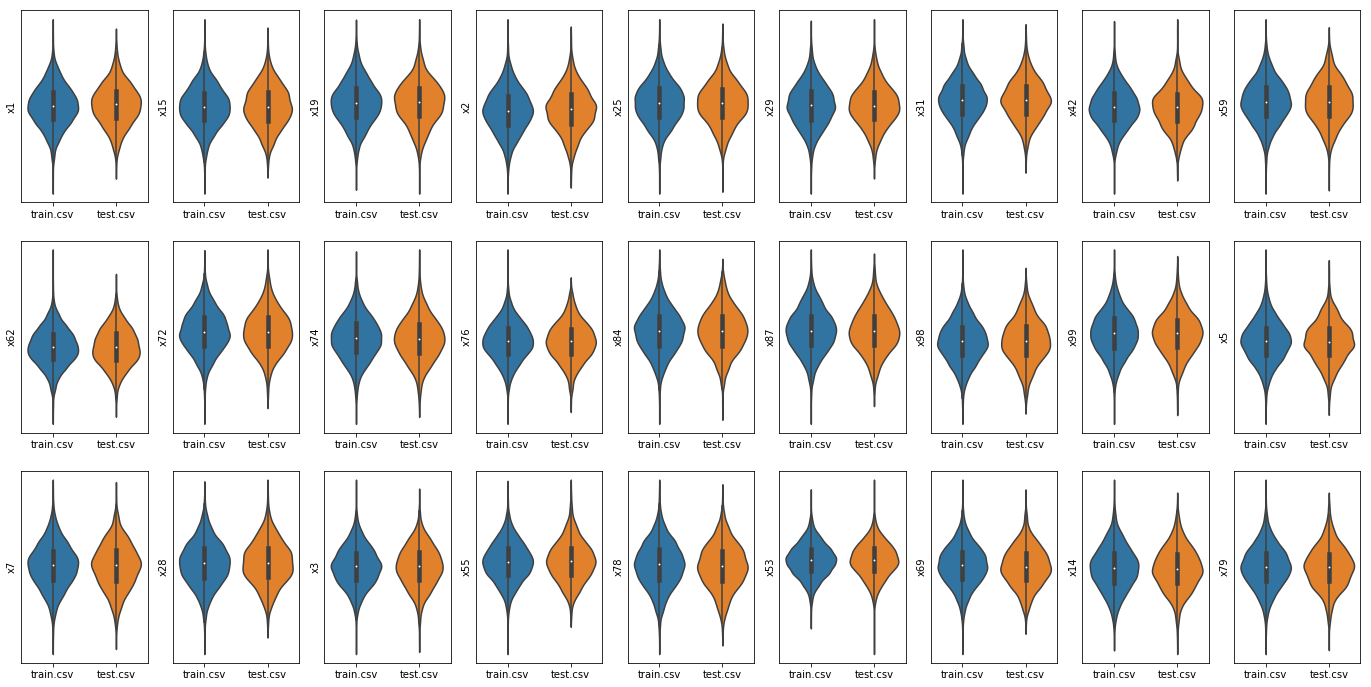

In [64]:
fig, axs = plt.subplots(3, 9, figsize=(24, 12))
for i in range(len(lm_weights.feature)):
    row_index = i // 9
    col_index = i % 9
    sns.violinplot(x="data_type", y=lm_weights.feature[i], data=merged_csv,
                   ax=axs[row_index][col_index])
    ax = axs[row_index][col_index]
    ax.set_yticks(())
    ax.set_xlabel("")

From the violinplots above we can see that, for each feature, the values from the **train.csv** and **test.csv** have very similar distribution. Therefore, the final model should perform well on the **test.csv** data set.

## Model 2: Gradient Boosting Regression Model Selection

### Split data into train and test sets

In [65]:
from sklearn.model_selection import GridSearchCV
train_X, test_X, train_Y, test_Y = model_selection.train_test_split(my_data, Y, test_size = 0.3, random_state=0)

### Build parameters search grid

In [160]:
param_grid = {
    'max_features': [10, 20, 30],
    'min_samples_leaf': [5, 10, 15],
    'max_depth': [5, 10, 20, 30]
}

### 10X Cross-Validation

In [ ]:
gbr_cv = GridSearchCV(ensemble.GradientBoostingRegressor(), cv=10, param_grid=param_grid,)

### Train Models

In [69]:
gbr_cv.fit(train_X, train_Y)

GridSearchCV(cv=10, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': [10, 20, 30], 'min_samples_leaf': [5, 10, 15], 'max_depth': [5, 10, 20, 30]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

### Save model

Training this model took a long time. We can save the trained model to a file.

In [172]:
from sklearn.externals import joblib

In [173]:
joblib.dump(gbr_cv, filename="results/model2.sav")

['results/model2.sav']

In [177]:
loaded_gbr_cv = joblib.load("results/model2.sav")
# loaded_gbr_cv.predict(train_X) # to load the trained model from file

## Train vs. Test Error

In [191]:
train_residual_sq = pd.DataFrame({
    'error': (train_Y - gbr_cv.best_estimator_.predict(train_X))**2,
    'type': 'train'
})
test_residual_sq = pd.DataFrame({
    'error': (test_Y - gbr_cv.best_estimator_.predict(test_X))**2,
    'type': 'test'
})
errors_df = pd.concat([train_residual_sq, test_residual_sq], axis=0)

best_train_score = round(gbr_cv.best_estimator_.score(train_X, train_Y), 3)
best_test_score = round(gbr_cv.best_estimator_.score(test_X, test_Y), 3)

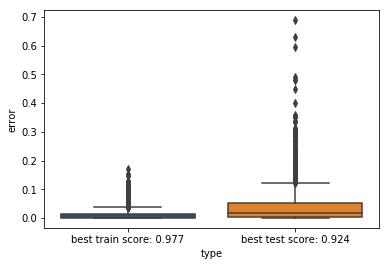

In [193]:
sns.boxplot(x="type", y="error", data=errors_df)
ax = plt.gca()
ax.set_xticklabels(['best train score: ' + str(best_train_score), 'best test score: ' + str(best_test_score)])
plt.show()

## Plot feature importance

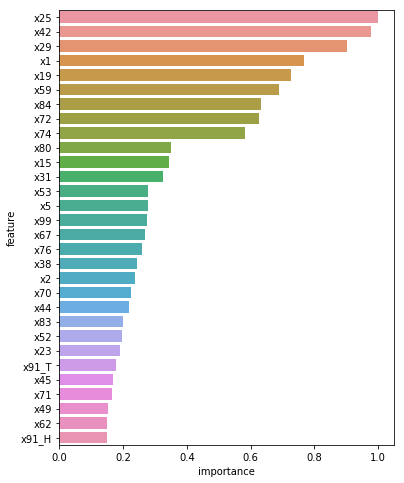

In [142]:
feature_impotances = list(zip(train_X.columns, 
                          gbr_cv.best_estimator_.feature_importances_/gbr_cv.best_estimator_.feature_importances_.max()))
feature_impotances_sorted = sorted(feature_impotances, key=lambda x: x[1], reverse=True)
feature_impotances_df = pd.DataFrame(feature_impotances_sorted, columns=['feature', 'importance'])
fig, ax = plt.subplots(figsize=(6, 8))
sns.barplot(y="feature", x="importance", data=feature_impotances_df.iloc[:30, ], ax=ax)
plt.show()

In [141]:
# list(set(lm_weights.feature) & set(feature_impotances_df.feature[:27]))

## Model 2 Submission

In [231]:
# import data
model2_test_data = pd.read_csv("data/test.csv")

# fill missing values in quantitative variables with median
for x in quantitative_variables:
    model2_test_data[x].fillna(model2_test_data[x].median(), inplace=True)
    
# fill missing values in categorical variables with mode
for x in categorical_variables:
    model2_test_data[x].fillna(model2_test_data[x].mode()[0], inplace=True)

# one hot encode categorical variables
model2_test_data_dummy_variables = pd.get_dummies(model2_test_data[categorical_variables])


# drop original categorical variables and replace them with dummy encoded variables.
model2_test_data.drop(categorical_variables, axis=1, inplace=True)
model2_test_data = pd.concat([model2_test_data_dummy_variables, model2_test_data], axis=1)


In [239]:
submission = gbr_cv.best_estimator_.predict(model2_test_data)
submission = pd.DataFrame(submission.reshape(1,2000))

In [241]:
submission.to_csv("results/model2_submission.csv", header=False, index=False)